<a href="https://colab.research.google.com/github/irravasyuk/SQL_2/blob/master/%D0%94%D0%97_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [59]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про гриби

[посилання](https://www.kaggle.com/datasets/uciml/mushroom-classification)

In [60]:
# трохи обробки даних
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані непогано збалансовані

In [61]:
df['class'].value_counts()

class
0    4208
1    3916
Name: count, dtype: int64

In [62]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


Потрібно на основі інформації про гриб зрозуміти чи він їстівним(клас 1) `class`

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     8124 non-null   int64  
 1   cap-shape                 8124 non-null   float64
 2   cap-surface               8124 non-null   float64
 3   cap-color                 8124 non-null   float64
 4   bruises                   8124 non-null   float64
 5   odor                      8124 non-null   float64
 6   gill-attachment           8124 non-null   float64
 7   gill-spacing              8124 non-null   float64
 8   gill-size                 8124 non-null   float64
 9   gill-color                8124 non-null   float64
 10  stalk-shape               8124 non-null   float64
 11  stalk-root                8124 non-null   float64
 12  stalk-surface-above-ring  8124 non-null   float64
 13  stalk-surface-below-ring  8124 non-null   float64
 14  stalk-co

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [64]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

X = df.drop(columns=['class'])
y = df['class']

dataset = MyDataset(X, y)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [66]:
dataset_train[0][0].shape

torch.Size([21])

# Завдання 2
Створіть DataLoader

In [67]:
from torch.utils.data import DataLoader

batch_size = 64
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True)

test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True)

# Завдання 3
Створіть нейромережу

In [68]:
from torch import nn
import torch.nn.functional as F


class Block(nn.Module):
  def __init__(self, x, y):
    super().__init__()

    self.linear_1 = nn.Linear(x, y)
    self.bnorm_1 = nn.BatchNorm1d(y)
    self.linear_2 = nn.Linear(y, y-2)
    self.linear_3 = nn.Linear(y-2, y-4)
    self.linear_4 = nn.Linear(y-4, y-6)


  def forward(self, x):
    out = self.linear_1(x)
    out = self.bnorm_1(out)
    out = F.leaky_relu(out)

    out = self.linear_2(out)
    out = F.leaky_relu(out)

    out = self.linear_3(out)
    out = F.leaky_relu(out)

    out = self.linear_4(out)
    out = F.leaky_relu(out)

    return out


In [69]:
class BinaryClassifie(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()

    self.model = nn.Sequential(
          Block(input_dim, hidden_dim),
          Block(hidden_dim-6, hidden_dim//4),


          nn.Linear(hidden_dim//10, output_dim),
          nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

  def predict(self, X, device="cpu"):
    X_data = torch.FloatTensor(X.values).to(device)

    with torch.no_grad():
      y_pred = self.forward(X_data)

    return y_pred.cpu().numpy().squeeze()


model = BinaryClassifie(21, 36, 1)
model

BinaryClassifie(
  (model): Sequential(
    (0): Block(
      (linear_1): Linear(in_features=21, out_features=36, bias=True)
      (bnorm_1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=36, out_features=34, bias=True)
      (linear_3): Linear(in_features=34, out_features=32, bias=True)
      (linear_4): Linear(in_features=32, out_features=30, bias=True)
    )
    (1): Block(
      (linear_1): Linear(in_features=30, out_features=9, bias=True)
      (bnorm_1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=9, out_features=7, bias=True)
      (linear_3): Linear(in_features=7, out_features=5, bias=True)
      (linear_4): Linear(in_features=5, out_features=3, bias=True)
    )
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [70]:
from torchsummary import summary

summary(model, input_size=(21,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 36]             792
       BatchNorm1d-2                   [-1, 36]              72
            Linear-3                   [-1, 34]           1,258
            Linear-4                   [-1, 32]           1,120
            Linear-5                   [-1, 30]             990
             Block-6                   [-1, 30]               0
            Linear-7                    [-1, 9]             279
       BatchNorm1d-8                    [-1, 9]              18
            Linear-9                    [-1, 7]              70
           Linear-10                    [-1, 5]              40
           Linear-11                    [-1, 3]              18
            Block-12                    [-1, 3]               0
           Linear-13                    [-1, 1]               4
          Sigmoid-14                   

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [71]:
loss_func = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [72]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=500, gamma=0.1)

# Завдання 5
Натренуйте нейромережу.

In [73]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='binary'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = F.sigmoid(y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = F.sigmoid(y_pred)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [74]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_func, train_dl, test_dl,
                epochs=50,
                metrics=[accuracy_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifie, opt=Adam(lr=0.100000), epochs=50, device=cpu

Epoch    1    1sec	loss:      0.161	val_loss:      0.124	accuracy_score:      0.492	val_accuracy_score:      0.482	
Epoch    2    1sec	loss:     0.0269	val_loss:     0.0139	accuracy_score:      0.564	val_accuracy_score:      0.697	
Epoch    3    1sec	loss:     0.0223	val_loss:      0.314	accuracy_score:      0.734	val_accuracy_score:      0.482	
Epoch    4    1sec	loss:     0.0556	val_loss:     0.0101	accuracy_score:      0.577	val_accuracy_score:      0.754	
Epoch    5    1sec	loss:     0.0152	val_loss:      0.125	accuracy_score:      0.742	val_accuracy_score:      0.649	
Epoch    6    1sec	loss:      0.144	val_loss:      0.201	accuracy_score:      0.519	val_accuracy_score:      0.482	
Epoch    7    1sec	loss:     0.0759	val_loss:     0.0478	accuracy_score:      0.533	val_accuracy_score:      0.482	
Epoch    8    1sec	loss:     0.0222	val_loss:   0.000445	accuracy_score:      0.761	val_accuracy_score:

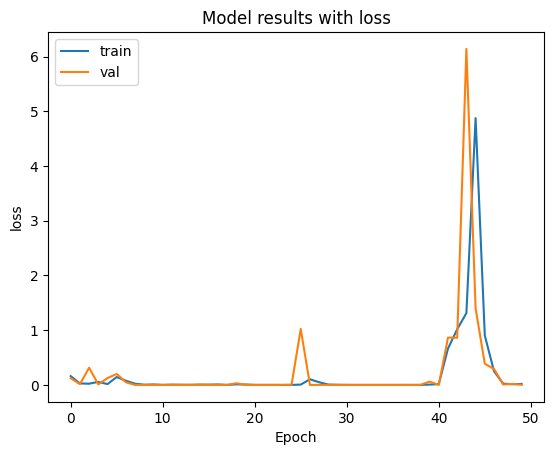

In [75]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

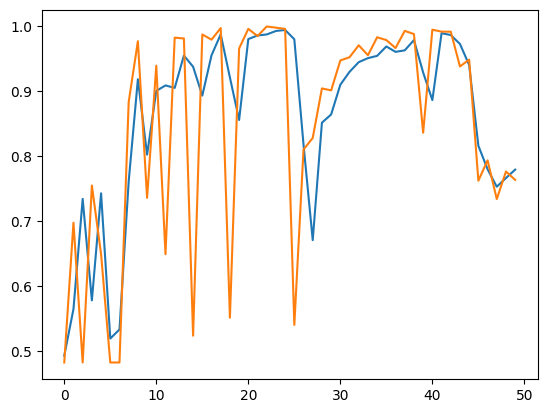

In [76]:
import matplotlib.pyplot as plt

plt.plot(history["accuracy_score"])
plt.plot(history["val_accuracy_score"])

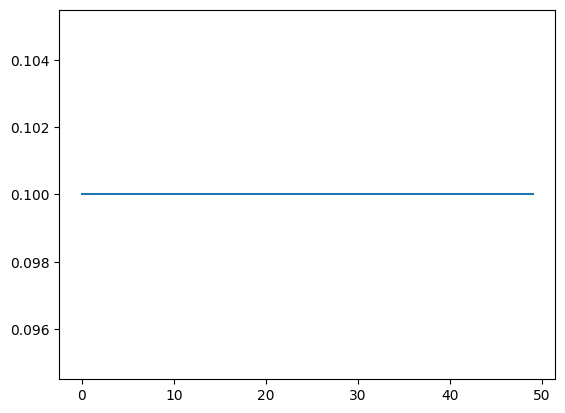

In [77]:
plt.plot(history['lr'])

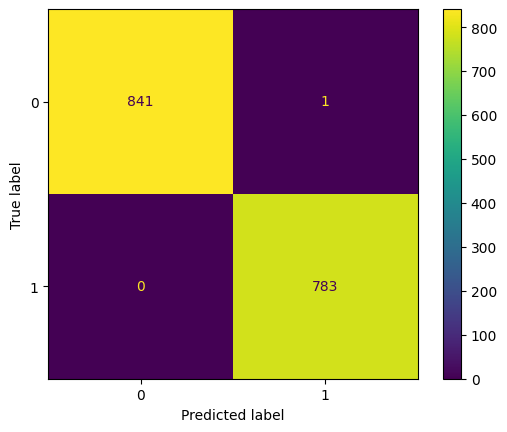

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [79]:
torch.save(model, 'model.pt')

In [80]:
load_model = torch.load('model.pt')

In [81]:
load_model

BinaryClassifie(
  (model): Sequential(
    (0): Block(
      (linear_1): Linear(in_features=21, out_features=36, bias=True)
      (bnorm_1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=36, out_features=34, bias=True)
      (linear_3): Linear(in_features=34, out_features=32, bias=True)
      (linear_4): Linear(in_features=32, out_features=30, bias=True)
    )
    (1): Block(
      (linear_1): Linear(in_features=30, out_features=9, bias=True)
      (bnorm_1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=9, out_features=7, bias=True)
      (linear_3): Linear(in_features=7, out_features=5, bias=True)
      (linear_4): Linear(in_features=5, out_features=3, bias=True)
    )
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [82]:
X.iloc[:1]

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1.0,0.666667,0.444444,1.0,0.75,1.0,0.0,1.0,0.363636,0.0,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.25,0.6,0.833333


In [83]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[1.0000, 0.6667, 0.4444, 1.0000, 0.7500, 1.0000, 0.0000, 1.0000, 0.3636,
         0.0000, 0.7500, 0.6667, 0.6667, 0.8750, 0.8750, 0.6667, 0.5000, 1.0000,
         0.2500, 0.6000, 0.8333]])
torch.Size([1, 21])


In [84]:
load_model(X_data)

tensor([[1.0000]], grad_fn=<SigmoidBackward0>)